# Detecting Emotion From Text

## Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import json

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords
import string
import re

from tqdm import tqdm
import seaborn as sns
from wordcloud import WordCloud
import pickle
import warnings
warnings.filterwarnings('ignore')

## Load Data - Go Emotions

In [2]:
data_train = pd.read_csv('./data/goEmotions/train.tsv', sep="\t", header=None, names=["text", "emotion", "temp"]).drop("temp", axis=1)
data_test = pd.read_csv('./data/goEmotions/test.tsv', sep="\t", header=None, names=["text", "emotion", "temp"]).drop("temp", axis=1)
data_val = pd.read_csv('./data/goEmotions/dev.tsv', sep="\t", header=None, names=["text", "emotion", "temp"]).drop("temp", axis=1)

In [3]:
data_go_Emotion = pd.concat([data_train, data_test, data_val])

In [4]:
data_go_Emotion

,text,emotion
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3
...,...,...
5421,It's pretty dangerous when the state decides w...,14
5422,I filed for divorce this morning. Hoping he mo...,20
5423,"The last time it happened I just said, ""No"" an...",10
5424,I can’t stand this arrogant prick he’s no bett...,3


In [5]:
def use_one(row):
    if "," in row:
        return row.split(",")[0]
    return row

In [6]:
data_go_Emotion.emotion = data_go_Emotion.emotion.apply(use_one)

In [7]:
data_go_Emotion.emotion.value_counts()

27    16021
0      5122
4      3269
1      2793
15     2681
3      2671
7      2210
10     2117
2      1936
18     1883
6      1543
9      1284
17     1250
20     1227
5      1218
25     1067
26      938
22      893
13      862
11      738
8       681
14      658
24      497
12      306
19      132
23      111
16       81
21       74
Name: emotion, dtype: int64

In [8]:
with open('./data/goEmotions/emotions.txt', 'r') as f:
    emotion_arr = f.readlines()
    emotion_arr = [x.replace("\n", "") for x in emotion_arr]

In [9]:
print(emotion_arr)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [10]:
with open("./data/goEmotions/ekman_mapping.json") as f:
    emotion_dict = json.loads(f.read())

In [11]:
emotion_dict["happiness"] = emotion_dict.pop("joy")

In [12]:
emotion_dict

{'anger': ['anger', 'annoyance', 'disapproval'],
 'disgust': ['disgust'],
 'fear': ['fear', 'nervousness'],
 'sadness': ['sadness', 'disappointment', 'embarrassment', 'grief', 'remorse'],
 'surprise': ['surprise', 'realization', 'confusion', 'curiosity'],
 'happiness': ['joy',
  'amusement',
  'approval',
  'excitement',
  'gratitude',
  'love',
  'optimism',
  'relief',
  'pride',
  'admiration',
  'desire',
  'caring']}

In [13]:
base_emotions = emotion_dict.keys()

In [14]:
def map_emotions(row):
    emt = emotion_arr[int(row)]
    if emt == "neutral":
        return emt
    for i in base_emotions:
        for j in emotion_dict[i]:
#             print(j)
            if emt == j:
                return i

In [15]:
temp = data_go_Emotion.emotion.apply(map_emotions)
temp.value_counts()

happiness    21171
neutral      16021
anger         6724
surprise      5584
sadness       3235
fear           790
disgust        738
Name: emotion, dtype: int64

In [16]:
data_go_Emotion.emotion = data_go_Emotion.emotion.apply(map_emotions)

In [17]:
data_go_Emotion

,text,emotion
0,My favourite food is anything I didn't have to...,neutral
1,"Now if he does off himself, everyone will thin...",neutral
2,WHY THE FUCK IS BAYLESS ISOING,anger
3,To make her feel threatened,fear
4,Dirty Southern Wankers,anger
...,...,...
5421,It's pretty dangerous when the state decides w...,fear
5422,I filed for divorce this morning. Hoping he mo...,happiness
5423,"The last time it happened I just said, ""No"" an...",anger
5424,I can’t stand this arrogant prick he’s no bett...,anger


## Load Data - Sunflower Data.World

In [18]:
data_sun = pd.read_csv("./data/data_world_emotions/text_emotion.csv")
data_sun = data_sun[["sentiment", "content"]]
data_sun = data_sun.rename({"sentiment": "emotion", "content":"text"}, axis=1)

In [19]:
emt = ['empty', 'sadness', 'enthusiasm', 'neutral', 'surprise','love', 'fun', 'hate', 'happiness', 'anger']
emt_dict = {'empty': 'sadness', "enthusiasm": "happiness", "fun": "happiness", "love": "happiness", "hate":"anger" }

def map_emotion(emotion):
    if emotion in emt:
        if emotion in emt_dict:
            return emt_dict[emotion]
        return emotion
    return None

In [20]:
data_sun.emotion = data_sun.emotion.apply(map_emotion)
data_sun = data_sun.dropna()

In [21]:
data_sun.emotion.value_counts()

happiness    11586
neutral       8638
sadness       5992
surprise      2187
anger         1433
Name: emotion, dtype: int64

## Load Data - Github Dataset

In [22]:
data_gt = pd.read_csv("./data/github_emotions/emotion_data.csv", header=None, names=["text", "emotion"])
data_gt

,text,emotion
0,i m looking forward to going home tomorrow but...,2
1,just got to kansas city and excited for a fun ...,3
2,hey adt guess what my princelple s number plat...,1
3,b gt not the best song for her,0
4,the wind tried to hate on us today lol hello f...,4
...,...,...
55769,vancouver so classy canuck s,1
55770,gonna get my ticket to las vegas today gotta c...,1
55771,when life as you know it doesn t exist anymore,2
55772,my camera is brokennn,2


In [23]:
emotion_arr = ["neutral", "happiness", "sadness", "Love", "anger"]

def map_classes(emotion):
    if int(emotion) != 3:
        return emotion_arr[int(emotion)]
    return emotion_arr[2]

In [24]:
data_gt.emotion = data_gt.emotion.apply(map_classes)

In [25]:
data_gt.emotion.value_counts()

sadness      24499
happiness    15444
neutral       9643
anger         6188
Name: emotion, dtype: int64

## Complete Dataset

In [26]:
# data = pd.concat([data_go_Emotion, data_sun, data_gt])
data = pd.concat([data_go_Emotion])
data = data.dropna().reset_index(drop=True)

In [27]:
data

,text,emotion
0,My favourite food is anything I didn't have to...,neutral
1,"Now if he does off himself, everyone will thin...",neutral
2,WHY THE FUCK IS BAYLESS ISOING,anger
3,To make her feel threatened,fear
4,Dirty Southern Wankers,anger
...,...,...
54258,It's pretty dangerous when the state decides w...,fear
54259,I filed for divorce this morning. Hoping he mo...,happiness
54260,"The last time it happened I just said, ""No"" an...",anger
54261,I can’t stand this arrogant prick he’s no bett...,anger


## EDA

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54263 entries, 0 to 54262
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     54263 non-null  object
 1   emotion  54263 non-null  object
dtypes: object(2)
memory usage: 848.0+ KB


In [29]:
data["emotion"].value_counts()

happiness    21171
neutral      16021
anger         6724
surprise      5584
sadness       3235
fear           790
disgust        738
Name: emotion, dtype: int64

In [30]:
data = data[data.emotion != "fear"]
data = data[data.emotion != "disgust"]

## Data Preprocessing Pipeline

In [31]:
# Tweets cleaning

def remove_hashtags_mentions(sent):
    removed_mentions = re.sub("@[A-Za-z0-9_]+", "", sent)
    removed_hashtags = re.sub("#[A-Za-z0-9_]+","", removed_mentions)
    return removed_hashtags

In [32]:
# lowercase
def lower_case(sent):
    return sent.lower()

In [33]:
# Removing Punctuation
def remove_punctuation(sent):
    return " ".join([char for char in sent.split() if char not in string.punctuation])

In [34]:
def filter_stopwords(tokens):
    return " ".join([word for word in tokens.split() if word not in stop_words])

In [35]:
def preprocess_pipeline(sentence):
    
    sent = remove_hashtags_mentions(sentence)
    sent = lower_case(sent)
    sent = remove_punctuation(sent)
    
    return sent

### Preprocess the Data

In [36]:
data["preprocessed text"] = data["text"].apply(preprocess_pipeline)

In [37]:
data.head()

,text,emotion,preprocessed text
0,My favourite food is anything I didn't have to...,neutral,my favourite food is anything i didn't have to...
1,"Now if he does off himself, everyone will thin...",neutral,"now if he does off himself, everyone will thin..."
2,WHY THE FUCK IS BAYLESS ISOING,anger,why the fuck is bayless isoing
4,Dirty Southern Wankers,anger,dirty southern wankers
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,surprise,omg peyton isn't good enough to help us in the...


## Building Tokenizer

In [38]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data["preprocessed text"].values)

word_index = tokenizer.word_index
vocab_size=len(word_index)

In [39]:
embedding_dim = 300
max_length = 350
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [40]:
sequences = tokenizer.texts_to_sequences(data["preprocessed text"].values)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [41]:
with open("./API/emotion_tokenizer.obj", "wb") as f:
    pickle.dump(tokenizer, f)

## Train Test Split

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(padded, data["emotion"], test_size=0.3, stratify=data["emotion"])

In [44]:
len(X_train), len(X_test), len(y_train), len(y_test)

(36914, 15821, 36914, 15821)

## Encode Data

In [45]:
from sklearn.preprocessing import OneHotEncoder

In [46]:
en = OneHotEncoder()

In [47]:
y_train = en.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_test = en.transform(y_test.values.reshape(-1, 1)).toarray()

In [48]:
encoder = list(en.categories_)
encoder

[array(['anger', 'happiness', 'neutral', 'sadness', 'surprise'],
       dtype=object)]

In [49]:
y_train[0]

array([0., 0., 1., 0., 0.])

## Load Glove Embedding

In [50]:
# 300 dimension version of GloVe from Stanford

embeddings_index = {};
with open('./pre_trained_Embedding/glove.6B/glove.6B.300d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [51]:
print(len(embeddings_matrix))

31166


## Building the AI Model I - Bi - LSTM

In [67]:
def get_model():

    model = tf.keras.Sequential()
    model.add(Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix]))
    #     model.add(Bidirectional(tf.keras.layers.LSTM(16)))
    model.add(Bidirectional(tf.keras.layers.GRU(32)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [68]:
model = get_model()

In [69]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 350, 300)          9349800   
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               64128     
 nal)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 128)               8320      
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                      

## Training the AI model

In [70]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
            tf.keras.callbacks.ModelCheckpoint(
              filepath='./models/emotion_pred_model.h5',
              save_weights_only=False,
              monitor='val_loss',
              save_best_only=True),
            ]

In [71]:
history = model.fit(X_train, y_train, batch_size=32, epochs=1000, validation_data=(X_test, y_test),callbacks = [callback])

Epoch 1/1000
1154/1154 [==============================] - 51s 43ms/step - loss: 1.1489 - accuracy: 0.5513 - val_loss: 0.9807 - val_accuracy: 0.6148
Epoch 2/1000
1154/1154 [==============================] - 50s 43ms/step - loss: 0.9045 - accuracy: 0.6606 - val_loss: 0.9673 - val_accuracy: 0.6302
Epoch 3/1000
1154/1154 [==============================] - 50s 44ms/step - loss: 0.7167 - accuracy: 0.7419 - val_loss: 1.0451 - val_accuracy: 0.6067
Epoch 4/1000
1154/1154 [==============================] - 49s 43ms/step - loss: 0.5374 - accuracy: 0.8162 - val_loss: 1.2472 - val_accuracy: 0.5990
Epoch 5/1000
1154/1154 [==============================] - 50s 43ms/step - loss: 0.4086 - accuracy: 0.8648 - val_loss: 1.5555 - val_accuracy: 0.5849


In [72]:
model = load_model("./models/emotion_pred_model.h5")

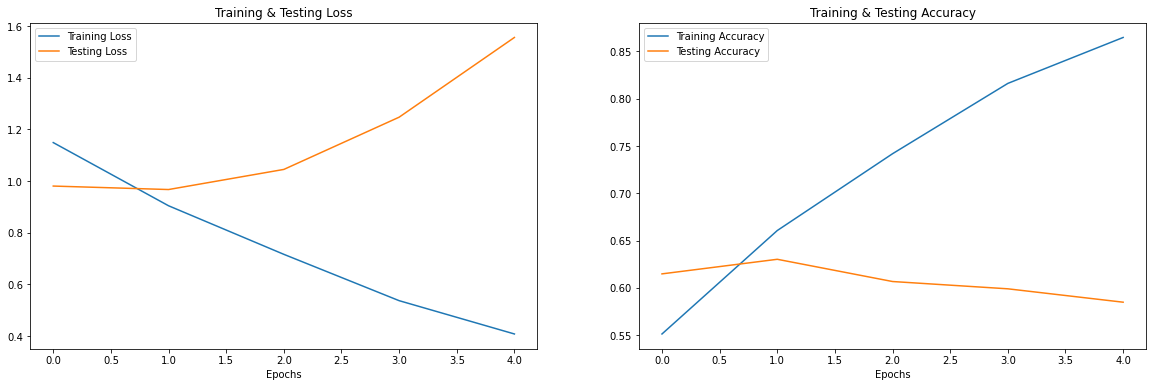

In [74]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [75]:
model.evaluate(X_test, y_test)

495/495 [==============================] - 8s 16ms/step - loss: 0.9673 - accuracy: 0.6302


[0.9673157930374146, 0.6302382946014404]

In [76]:
pred = model.predict(X_test)

In [77]:
pred = [np.argmax(x) for x in pred]

In [78]:
y_test_v = [np.argmax(x) for x in y_test]

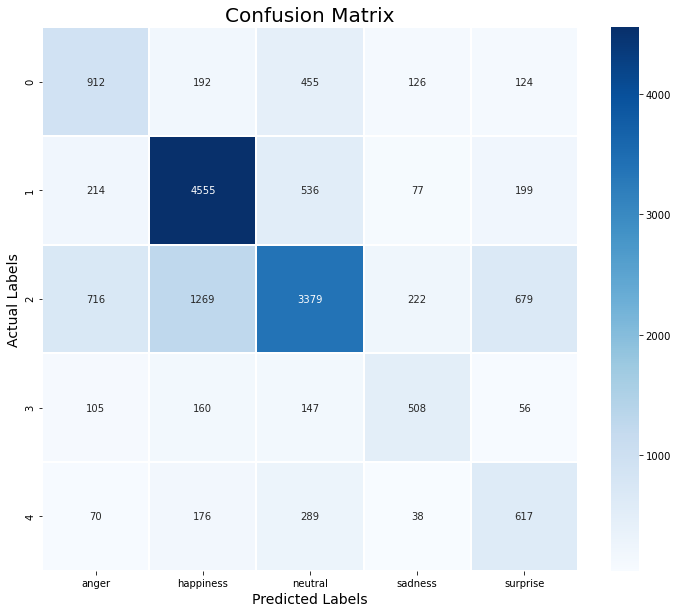

In [79]:
cm = confusion_matrix(pred, y_test_v)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , columns = en.categories_[0])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [80]:
print(classification_report(pred, y_test_v, target_names=en.categories_[0]))

              precision    recall  f1-score   support

       anger       0.45      0.50      0.48      1809
   happiness       0.72      0.82      0.76      5581
     neutral       0.70      0.54      0.61      6265
     sadness       0.52      0.52      0.52       976
    surprise       0.37      0.52      0.43      1190

    accuracy                           0.63     15821
   macro avg       0.55      0.58      0.56     15821
weighted avg       0.64      0.63      0.63     15821



In [81]:
precision_score(pred, y_test_v, average="macro")

0.5527726652448904

In [82]:
recall_score(pred, y_test_v, average="macro")

0.5797265367978068

In [83]:
f1_score(pred, y_test_v, average="macro")

0.5606269738739269

## Inference

In [84]:
# Tweets cleaning

def remove_hashtags_mentions(sent):
    removed_mentions = re.sub("@[A-Za-z0-9_]+", "", sent)
    removed_hashtags = re.sub("#[A-Za-z0-9_]+","", removed_mentions)
    return removed_hashtags

In [85]:
# lowercase
def lower_case(sent):
    return sent.lower()

In [86]:
# Removing Punctuation
def remove_punctuation(sent):
    return " ".join([char for char in sent.split() if char not in string.punctuation])

In [87]:
def clean_pipeline(sentence):
    
    sent = remove_hashtags_mentions(sentence)
    sent = lower_case(sent)
    sent = remove_punctuation(sent)
    
    return sent

In [88]:
embedding_dim = 300
max_length = 350
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [89]:
sequences = tokenizer.texts_to_sequences(data["preprocessed text"].values)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [90]:
emotion_dict = ['anger', 'happiness', 'neutral', 'sadness', 'surprise']

In [56]:
model = load_model("./API/emotion_pred_model.h5")

In [93]:
def emotion_inference(text):
    if type(text) is str:
        p_text = clean_pipeline(text)
        sequences = tokenizer.texts_to_sequences([p_text])
    else:
        p_text = [clean_pipeline(x) for x in text]
        sequences = tokenizer.texts_to_sequences(p_text)
        
    padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    padded = np.array(padded)
    
    pred_l = model.predict(padded)
    
    pred = [np.argmax(x) for x in pred_l]
    emotion = [emotion_dict[x] for x in pred]
    
    percentage = [x * 100 for x in pred_l]
    percentage = [list(map(str, l)) for l in percentage]
    
    return list(zip(emotion, percentage))

In [94]:
emotion_inference(["I hate you all", " I like yall", "OMG i never expected this"])

[('anger', ['88.61584', '0.9432026', '8.457604', '0.33976802', '1.6435978']),
 ('happiness',
  ['1.3874488', '88.896576', '7.6792283', '0.50293475', '1.5338088']),
 ('surprise',
  ['5.1574802', '20.700146', '26.207664', '6.1261406', '41.808567'])]

In [ ]:
emotion_inference("I hate you all")